**In this notebook we determine relevant wavelengths (bands) to be selected for dimensionality reduction using PCA**

In [1]:
import random
import matplotlib.lines as mlines
from scipy.signal import find_peaks
from preprocessing import *

**FX10 camera**

In [2]:
# Assemble dataset for training PCA - should include (equal amount of) data from all classes
CAMERA = 'FX10'
IMG_DIR = '../Data/cropped_hdf5'

# Healthy leaves
DATES = ['07SEPT2023', '08SEPT2023', '09SEPT2023', '10SEPT2023', '11SEPT2023', '12SEPT2023',
         '13SEPT2023', '14SEPT2023', '15SEPT2023', '18SEPT2023', '19SEPT2023']
TRAYS = ['3D', '4C', '4D', '2D']    # Some files from the FX17 camera are mistakenly named in 2D instead of 4D
healthy_FX10 = filter_filenames(folder_path=IMG_DIR, camera_id=CAMERA, date_stamps=DATES, tray_ids=TRAYS)

# Early diseased leaves
DATES = ['07SEPT2023']
TRAYS = ['3C']
early_diseased_FX10 = filter_filenames(folder_path=IMG_DIR, camera_id=CAMERA, date_stamps=DATES, tray_ids=TRAYS)

# Mid diseased leaves
DATES = ['08SEPT2023', '09SEPT2023']
TRAYS = ['3C']
mid_diseased_FX10 = filter_filenames(folder_path=IMG_DIR, camera_id=CAMERA, date_stamps=DATES, tray_ids=TRAYS)

# Late diseased leaves
DATES = ['10SEPT2023', '11SEPT2023', '12SEPT2023', '13SEPT2023', '14SEPT2023', '15SEPT2023']
TRAYS = ['3C']
late_diseased_FX10 = filter_filenames(folder_path=IMG_DIR, camera_id=CAMERA, date_stamps=DATES, tray_ids=TRAYS)

# Number of samples in each category
print(f'Healthy: {len(healthy_FX10)}')
print(f'Early diseased: {len(early_diseased_FX10)}')
print(f'Mid diseased: {len(mid_diseased_FX10)}')
print(f'Late diseased: {len(late_diseased_FX10)}')
print('-----------------------------------')

# Sample 12 images from healthy, mid-and late-diseased leaves
random.seed(10)
healthy_sample = random.sample(healthy_FX10, 12)
mid_diseased_sample = random.sample(mid_diseased_FX10, 12)
late_diseased_sample = random.sample(late_diseased_FX10, 12)

print(f'Healthy after sampling: {len(healthy_sample)}')
print(f'Mid diseased after sampling: {len(mid_diseased_sample)}')
print(f'Late diseased after sampling: {len(late_diseased_sample)}')

print(healthy_sample)
print(mid_diseased_sample)
print(late_diseased_sample)
print('-----------------------------------')

# Concatenate the lists
pca_data = healthy_sample + early_diseased_FX10 + mid_diseased_sample + late_diseased_sample
print(f'Total number of samples for band selection based on PCA: {len(pca_data)}')

Healthy: 321
Early diseased: 12
Mid diseased: 25
Late diseased: 30
-----------------------------------
Healthy after sampling: 12
Mid diseased after sampling: 12
Late diseased after sampling: 12
['../Data/cropped_hdf5\\FX10_18SEPT2023_4D3_0.hdf5', '../Data/cropped_hdf5\\FX10_07SEPT2023_4D2_0.hdf5', '../Data/cropped_hdf5\\FX10_14SEPT2023_3D1_0.hdf5', '../Data/cropped_hdf5\\FX10_14SEPT2023_4D4_3.hdf5', '../Data/cropped_hdf5\\FX10_18SEPT2023_4D4_1.hdf5', '../Data/cropped_hdf5\\FX10_07SEPT2023_3D5_1.hdf5', '../Data/cropped_hdf5\\FX10_10SEPT2023_4D4_1.hdf5', '../Data/cropped_hdf5\\FX10_14SEPT2023_4C5_4.hdf5', '../Data/cropped_hdf5\\FX10_14SEPT2023_4D5_2.hdf5', '../Data/cropped_hdf5\\FX10_11SEPT2023_4D3_2.hdf5', '../Data/cropped_hdf5\\FX10_10SEPT2023_3D3_1.hdf5', '../Data/cropped_hdf5\\FX10_07SEPT2023_4D2_1.hdf5']
['../Data/cropped_hdf5\\FX10_09SEPT2023_3C2_7.hdf5', '../Data/cropped_hdf5\\FX10_09SEPT2023_3C2_3.hdf5', '../Data/cropped_hdf5\\FX10_08SEPT2023_3C4_2.hdf5', '../Data/cropped_hdf5\\

First conduct PCA on a large number of components (now 30) and then select a more appropriate number of PCs

In [3]:
# Preprocess data
X = load_and_flatten_hsi(img_paths=pca_data, mask_dir='../Data/cropped_masks',
                         apply_mask=True, individual_normalize=True, mask_method=0, min_wavelength=430)
print(f"Data shape before PCA: {X.shape}")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=30)    # Keep 30 components
X_pca = pca.fit_transform(X_scaled)

# Print results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("---------------------------------")
print(f"Number of components chosen: {pca.n_components_}")
print(f"Explained variance ratio: {cumulative_variance_ratio[-1]:.4f}")
print(f"Data shape after PCA: {X_pca.shape}")

Data shape before PCA: (2422891, 211)
---------------------------------
Number of components chosen: 30
Explained variance ratio: 0.9972
Data shape after PCA: (2422891, 30)


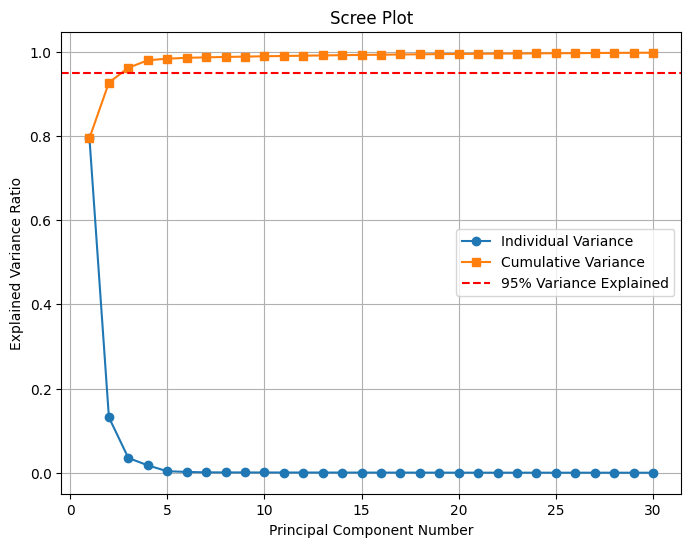

In [4]:
# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='s', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

Based on scree plot, there's an elbow at around 3/4/5 PCs. To help decide how many PCs to choose (which PCs doesn't only capture noise), we look at PC score images.

In [5]:
# Sample a random healthy, early, mid, and late diseased leaf for visualization
sample_healthy = '../Data/cropped_hdf5/FX10_10SEPT2023_4D4_1.hdf5'
sample_early = '../Data/cropped_hdf5/FX10_07SEPT2023_3C2_2.hdf5'
sample_mid = '../Data/cropped_hdf5/FX10_08SEPT2023_3C4_1.hdf5'
sample_late = '../Data/cropped_hdf5/FX10_14SEPT2023_3C3_2.hdf5'

sample_healthy, wlens = LoadHSI(sample_healthy, return_wlens=True)
sample_healthy, _ = preprocess(sample_healthy, wlens, min_wavelength=430, normalize=True)

sample_early = LoadHSI(sample_early)
sample_early, _ = preprocess(sample_early, wlens, min_wavelength=430, normalize=True)

sample_mid = LoadHSI(sample_mid)
sample_mid, _ = preprocess(sample_mid, wlens, min_wavelength=430, normalize=True)

sample_late = LoadHSI(sample_late)
sample_late, wlens = preprocess(sample_late, wlens, min_wavelength=430, normalize=True)

# Data in PCA space
sample_healthy_pca = hsi_transform_to_pca_space(sample_healthy, pca, scaler, mask_np=None)
sample_early_pca = hsi_transform_to_pca_space(sample_early, pca, scaler, mask_np=None)
sample_mid_pca = hsi_transform_to_pca_space(sample_mid, pca, scaler, mask_np=None)
sample_late_pca = hsi_transform_to_pca_space(sample_late, pca, scaler, mask_np=None)

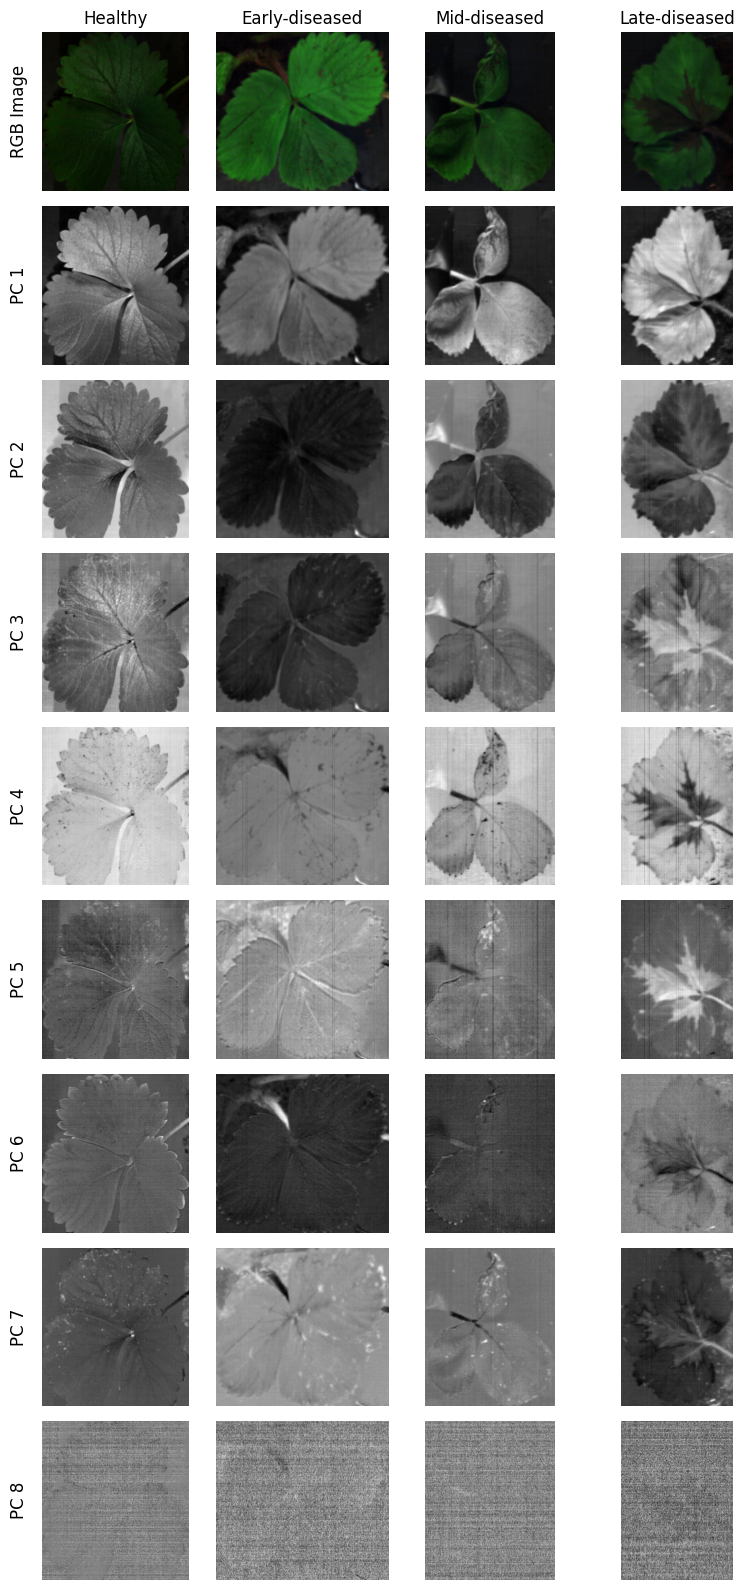

In [6]:
# Define the samples and their labels
samples = {
    "Healthy": sample_healthy,
    "Early-diseased": sample_early,
    "Mid-diseased": sample_mid,
    "Late-diseased": sample_late
}

# Convert to PCA space
samples_pca = {label: hsi_transform_to_pca_space(hsi, pca, scaler) for label, hsi in samples.items()}

# Get the bands for false RGB
RGB_wlens = (685, 550, 450)
RGB_bands = np.argmin(np.abs(np.array(wlens)[:, np.newaxis] - RGB_wlens), axis=0)

# Extract RGB images
rgb_images = {label: hsi[RGB_bands].transpose((1,2,0)) for label, hsi in samples.items()}

# Number of PCs to visualize
n_pcs = 8

# Create figure with a grid layout
fig, axes = plt.subplots(n_pcs + 1, len(samples), figsize=(8, 16))

# Plot RGB images (first row)
for i, (label, rgb_img) in enumerate(rgb_images.items()):
    ax = axes[0, i]
    ax.imshow(rgb_img)
    ax.set_title(label, fontsize=12)
    
    # Remove tick marks, frame
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # Add "RGB Image" label only on the first column
    if i == 0:
        ax.set_ylabel("RGB Image", fontsize=12, labelpad=10, rotation=90)

# Plot PC images
for pc_idx in range(n_pcs):
    for i, (label, pca_img) in enumerate(samples_pca.items()):
        ax = axes[pc_idx + 1, i]
        pc_image = pca_img[pc_idx]
        # Minmax normalize image for better visualization - not relevant since no colorbar
        # pc_image = (pc_image - np.min(pc_image)) / (np.max(pc_image) - np.min(pc_image))
        ax.imshow(pc_image, cmap="gray")
        
        # Add PC labels only in the first column
        if i == 0:
            ax.set_ylabel(f"PC {pc_idx+1}", fontsize=12, labelpad=10, rotation=90)

        # Remove tick marks, frame
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
plt.tight_layout()
plt.show()

It seems like even though there's not much added variance for PC4/5/6/7, PCs start to captur noise from PC8, so keeping PC7 can still be justifiable. E.g. PC7 still seems to capture with high score a diseased area (so is PC5). PC6 seems to capture stem and crowns. PC1 captures overall difference between leaf and background, so is PC2 mainly (also black/dark color).

So we will keep 7 PCs

In [7]:
# Preprocess data
X = load_and_flatten_hsi(img_paths=pca_data, mask_dir='../Data/cropped_masks',
                         apply_mask=True, individual_normalize=True, mask_method=0, min_wavelength=430)
print(f"Data shape before PCA: {X.shape}")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=7)    # Keep 30 components
X_pca = pca.fit_transform(X_scaled)

# Print results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("---------------------------------")
print(f"Number of components chosen: {pca.n_components_}")
print(f"Explained variance ratio: {cumulative_variance_ratio[-1]:.4f}")
print(f"Data shape after PCA: {X_pca.shape}")

Data shape before PCA: (2422891, 211)
---------------------------------
Number of components chosen: 7
Explained variance ratio: 0.9862
Data shape after PCA: (2422891, 7)


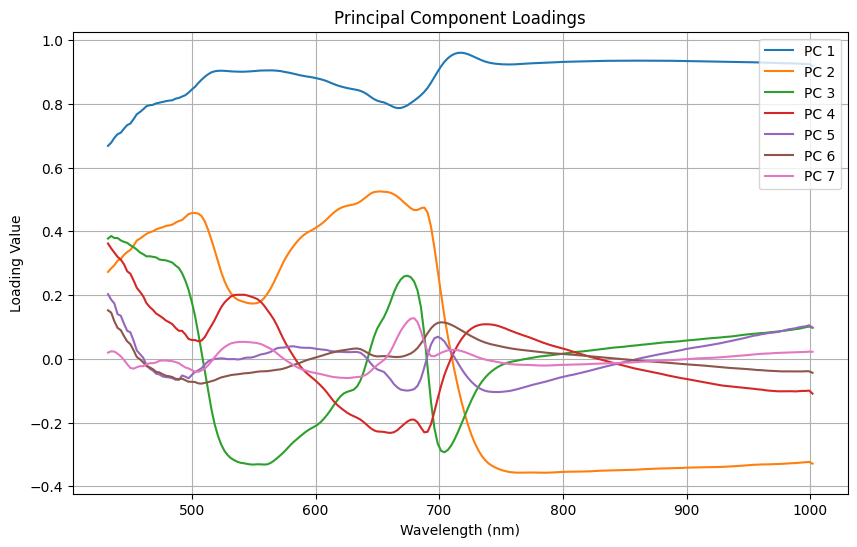

In [8]:
# Compute loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot PC loadings
plt.figure(figsize=(10, 6))
for i in range(pca.n_components_):
    plt.plot(wlens, loadings[:, i], label=f'PC {i+1}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Loading Value')
plt.title('Principal Component Loadings')
plt.legend()
plt.grid()
plt.show()

Now let's select important wavelengths based on prominent "peaks" and "valleys" (highs & lows / local maxima & local minima) based on the loadings

In [9]:
def find_important_wavelengths(wlens, loadings, prominence=0.02, distance=5):
    """
    Identify important wavelengths (peaks and valleys / local maximums and local minima) in PCA loadings.

    Parameters:
    - wlens (numpy array): Wavelength values with shape (bands, ) corresponding to bands in hsi_np and corresponding to the loadings now.
    - loadings (numpy array): PCA loadings of shape (num_wlens, num_components).
    - prominence (float): Minimum prominence of peaks/valleys to be considered significant.
    - distance (int): Required minimal horizontal distance (>= 1) in samples between neighbouring peaks or valleys.

    Returns:
    - important_wavelengths: dictionary with important wavelengths (peaks or valleys) for each PC.
    - merged_wavelengths: sorted list of unique important wavelengths across all PCs.
    """
    important_wavelengths = {}

    for i in range(loadings.shape[1]):
        pc_loadings = loadings[:, i]

        # Find significant peaks and valleys
        peaks, _ = find_peaks(pc_loadings, prominence=prominence, distance=distance)
        valleys, _ = find_peaks(-pc_loadings, prominence=prominence, distance=distance)

        # Combine and sort important wavelengths
        important_wl = np.sort(np.concatenate((wlens[peaks], wlens[valleys])))

        # Store important wavelengths
        important_wavelengths[f'PC{i+1}'] = important_wl

    # Merge all wavelengths into a single sorted unique list
    merged_wavelengths = np.sort(np.unique(np.concatenate(list(important_wavelengths.values()))))

    return important_wavelengths, merged_wavelengths

In [10]:
def plot_pca_loadings(wlens, loadings, important_wl, final_wl):
    """
    Plot PCA loadings with important wavelengths (marked with X) and final selected wavelengths (vertical lines).

    Parameters:
    - wlens (numpy array): Wavelength values with shape (bands, ) corresponding to bands in hsi_np and corresponding to the loadings now.
    - loadings (numpy array): PCA loadings of shape (num_wlens, num_components).
    - important_wl: dictionary with PCs as keys and arrays of important wavelengths as values. Output from find_important_wavelengths().
    - final_wl (numpy array): Final important wavelengths that we want to keep after band selection (possibly manually selected).
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, loadings.shape[1]))    # Colors for PCs

    for i, color in enumerate(colors):
        pc_loadings = loadings[:, i]

        # Plot the PCA loadings
        ax.plot(wlens, pc_loadings, label=f'PC {i+1}', color=color)

        # Overlay important wavelengths (peaks and valleys) for each PC marked with X on the PC loadings
        for wl in important_wl[f'PC{i+1}']:
            ax.scatter(wl, pc_loadings[np.argmin(np.abs(wlens - wl))], color=color, marker='x', s=60)

    # Plot selected wavelengths as vertical dashed lines
    for wl in final_wl:
        ax.axvline(x=wl, color="grey", linestyle="dashed", linewidth=1)

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('PC Loading')
    # ax.set_title('Principal Component Loadings with Important Wavelengths')

    # Create a custom legend entry for selected wavelengths
    selected_wl_legend = mlines.Line2D([], [], color='grey', linestyle='dashed', linewidth=1, label="selected\nwavelengths")

    # Add legend with the custom entry
    ax.legend(handles=[*ax.get_legend_handles_labels()[0], selected_wl_legend], fontsize=8, loc="center right", bbox_to_anchor=(1.035, 0.6))
    
    # Remove the top and right frame
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()

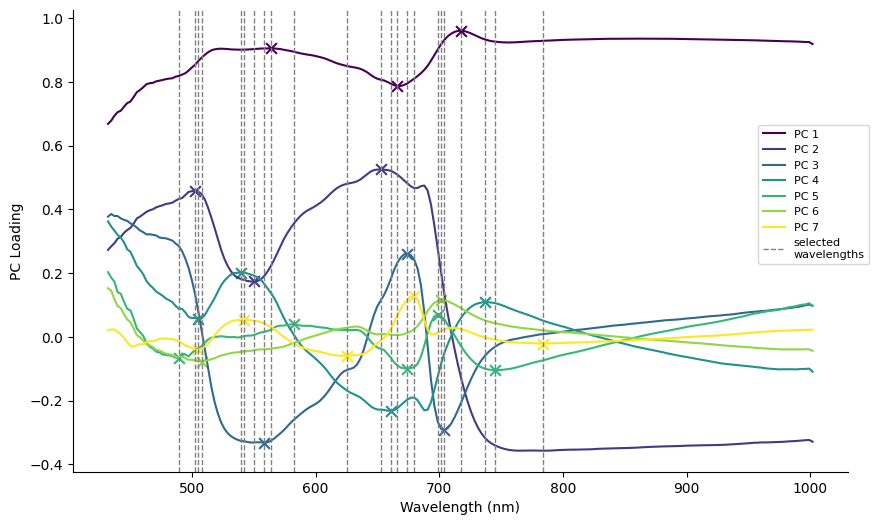

In [11]:
# Get a first run of important wavelengths and merged list, and plot them
important_wl, merged_wl = find_important_wavelengths(wlens, loadings, prominence=0.04, distance=5)
plot_pca_loadings(wlens, loadings, important_wl, merged_wl)

The vertical dashed lines in the previous plot shows all important wavelengths based on PC loading highs and lows. However some are very close to eachother and in these cases we select only a few from them (this is how they do it in literature as well), and also add 1-2 important wavelengths that were not detected - To be precise, 2 wavelengths after 800nm because those are not yet represented. Sure, there also weren't any prominent peaks/valleys in the loadings there but there are high/low loadings still (PC1&PC2) and we don't want to lose information from those wavelengths so we include 2.

This however requires some manual work, checking which wlens are close to eachother, deciding which to keep, which to remove and what to add. If there are importaant wlens close to each other, we'd rather keep those that are important for later PCs (PC3, PC5, PC7) because they show more prominent features for disease detection.

In [12]:
# These are the "default" important wavelengths so far
find_important_wavelengths(wlens, loadings, prominence=0.04, distance=5)

({'PC1': array([563.56, 666.05, 717.81]),
  'PC2': array([502.46, 550.2 , 652.48]),
  'PC3': array([558.21, 674.2 , 704.16]),
  'PC4': array([505.1 , 539.55, 660.62, 736.94]),
  'PC5': array([489.3 , 582.31, 674.2 , 698.71, 745.15]),
  'PC6': array([507.74, 701.44]),
  'PC7': array([505.1 , 542.21, 625.4 , 679.64, 783.52])},
 array([489.3 , 502.46, 505.1 , 507.74, 539.55, 542.21, 550.2 , 558.21,
        563.56, 582.31, 625.4 , 652.48, 660.62, 666.05, 674.2 , 679.64,
        698.71, 701.44, 704.16, 717.81, 736.94, 745.15, 783.52]))

In [13]:
# These are the actual wavelengths - printing it so we can select 1-2 of them to add to our important wavelengths
print(wlens)

[ 432.03  434.61  437.19  439.78  442.36  444.95  447.54  450.14  452.73
  455.33  457.93  460.53  463.14  465.74  468.35  470.96  473.58  476.19
  478.81  481.43  484.05  486.68  489.3   491.93  494.56  497.19  499.83
  502.46  505.1   507.74  510.38  513.02  515.67  518.31  520.96  523.61
  526.26  528.92  531.57  534.23  536.89  539.55  542.21  544.87  547.54
  550.2   552.87  555.54  558.21  560.88  563.56  566.23  568.91  571.59
  574.26  576.95  579.63  582.31  584.99  587.68  590.37  593.06  595.74
  598.44  601.13  603.82  606.51  609.21  611.91  614.6   617.3   620.
  622.7   625.4   628.11  630.81  633.52  636.22  638.93  641.64  644.35
  647.06  649.77  652.48  655.19  657.91  660.62  663.33  666.05  668.77
  671.49  674.2   676.92  679.64  682.37  685.09  687.81  690.53  693.26
  695.98  698.71  701.44  704.16  706.89  709.62  712.35  715.08  717.81
  720.54  723.27  726.    728.74  731.47  734.21  736.94  739.68  742.41
  745.15  747.89  750.62  753.36  756.1   758.84  761

There are 3 wlens very close to eachother after 500nm: 502.46, 505.1, 507.74. The 505.46 is for PC2 which is less relevant for disease detection (based on PC images), 505.1 is important for both PC4 and PC7, 507.74 is only important for PC6, so we will keep 505.1 and that was also in the middle anyways.

There are also 5 wlens fairly close to eachother around 550nm: 539.55, 542.21, 550.2, 558.21, 563.56. Out of these we keep 3, and drop 539.55 (that was for PC4 vs the closest to it 542.21 is for PC7. Both PCs might be relevant for disease detection, but the two wlens are literally besides eachother so we drop one), and also drop 563.56 which was an important wlens for PC1 and we know from the PC images that PC1 is less relevant for disease detection.

There are also 5 wlens fairly close to eachother around 650-680nm: 652.48, 660.62, 666.05, 674.2, 679.64. Out of these, 652.48 is relevant for PC2 and 666.05 for PC1, so we drop these two and keep the remaining three.

There are also 3 wlens very close to eachother at 700nm: 698.71, 701.44, 704.16. They are also literally wlens besides eachother (from the original 224 wlens /or 211 after removing <430nm/). Neither of them is for PC1 or PC2 so we keep the middle, which is 701.44 and drop the other two. 

We also add 2 wlens manually, because we see that none were selected after 800nm and we don't want to lose information from there either (also during data exploration we saw that there might be differences there as well in the spectra of healthy and infected leaves). There's a point around 850nm where PC3-PC7 all have around 0 loading, we want to avoid selecting that so we select one a bit to the right from that: 866.08 and one between 900 and 1000: 951.83.

In [14]:
selected_wlens = np.copy(merged_wl)
# Remove some wavelengths
selected_wlens = selected_wlens[~np.isin(selected_wlens, [502.46, 507.74, 539.55, 563.56, 652.48, 666.05, 698.71, 704.16])]
# Add some wavelengths
selected_wlens = np.append(selected_wlens, [866.08, 951.83])

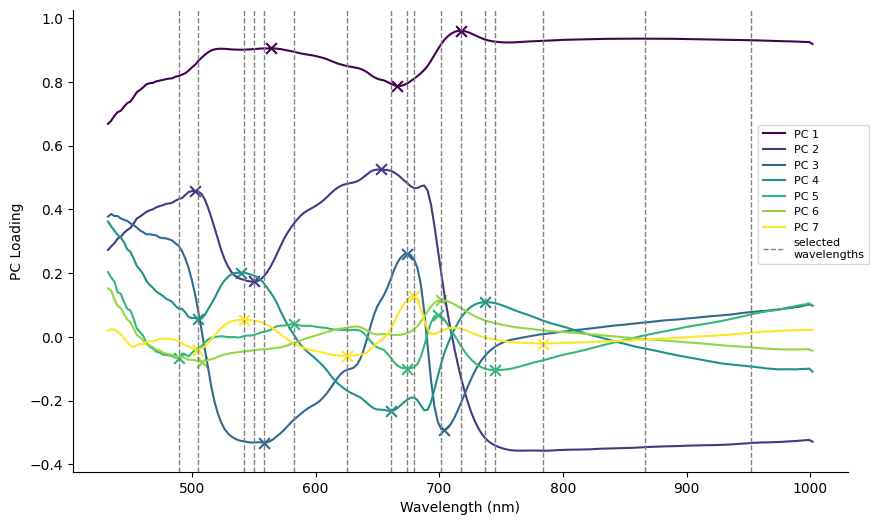

In [15]:
# Plot with final selected wavelengths
plot_pca_loadings(wlens, loadings, important_wl, selected_wlens)

Demonstration on how to filter hsi_np for the selected wavelengths only

In [16]:
# Load an example HSI and wlens
hsi_np, wlens = LoadHSI('../Data/cropped_hdf5/FX10_14SEPT2023_3C3_2.hdf5', return_wlens=True)
print(f"Original HSI shape: {hsi_np.shape}, Wavelengths: {wlens.shape}")

# Preprocess it (this also includes removing some wlens at the beginning but could be without that as well)
hsi_np, wlens = preprocess(hsi_np, wlens, min_wavelength=430, normalize=True)
print(f"Preprocessed HSI shape: {hsi_np.shape}, Wavelengths: {wlens.shape}")

print('-----------------------------------')

# Get the indices of selected_wl in the "original" (or preprocessed) wlens array
selected_wlens = np.sort(selected_wlens)
print(f"Final selected wavelengths: {selected_wlens}")
print(f"Number of final selected wavelengths: {len(selected_wlens)}")
indices = np.searchsorted(wlens, selected_wlens)
print(f"Indices of final wavelengths in original wlens: {indices}")

print('-----------------------------------')

# Extract the selected bands from the original (or preprocessed) HSI
selected_bands = hsi_np[indices,:,]
print(f"HSI shape after band selection: {selected_bands.shape}")

Original HSI shape: (224, 290, 204), Wavelengths: (224,)
Preprocessed HSI shape: (211, 290, 204), Wavelengths: (211,)
-----------------------------------
Final selected wavelengths: [489.3  505.1  542.21 550.2  558.21 582.31 625.4  660.62 674.2  679.64
 701.44 717.81 736.94 745.15 783.52 866.08 951.83]
Number of final selected wavelengths: 17
Indices of final wavelengths in original wlens: [ 22  28  42  45  48  57  73  86  91  93 101 107 114 117 131 161 192]
-----------------------------------
HSI shape after band selection: (17, 290, 204)
